In [30]:
import jax
from jax import grad, jit, lax, random, vmap
from jax.experimental.ode import odeint
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import evofr as ef

In [31]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
#import relative_fitness_gp
from ode_models import two_variant_model, three_variant_model

In [32]:
# Simulate two-variant SIR

## Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type

gen_wt = 1.8 # Average length of infection (days): 1 / gam_wt
eta_T = 1.5 # Transmissibility increase
eta_E = 0.7 * eta_T # Escape fraction 

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

In [33]:
#####  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E)

# Simulate first wave with no variants
# S0, I_wt, I_ve, I_vt, R_wt, R_ve, Inc_wt, Inc_ve, Inc_vt
u01 = jnp.array([0.999, 
                 0.0001, 0.0, 0.0, 
                 0.0, 0.0, 0.0,
                 0.0, 0.0, 0.0])
t1 = jnp.arange(20.)
Y1 = odeint(three_variant_model, u01, t1, true_θ)

# Simulate second wave with transmissibility variant
u02 = Y1[-1, :].at[3].add(1e-5)
t2 = jnp.arange(50.) + t1[-1] + 1
Y2 = odeint(three_variant_model, u02, t2, true_θ)

# Simulate third wave with escape variant
u03 = Y2[-1, :].at[2].add(1e-6)
t3 = jnp.arange(50.) + t2[-1] + 1
Y3 = odeint(three_variant_model, u03, t3, true_θ)

# Combine outputs and unpack
t = jnp.concatenate((t1, t2, t3))
Y = jnp.concatenate((Y1, Y2[1:,:], Y3[1:,:]), axis=0)

S, I_wt, I_ve,  I_vt = Y[:,0], Y[:, 1], Y[:, 2], Y[:, 3]
phi_wt, phi_ve, phi_vt  = Y[:, 4], Y[:, 5], Y[:,6]
Inc_wt, Inc_ve, Inc_vt = Y[:, 7], Y[:, 8], Y[:, 9]

In [34]:
PRES_PATH = "../manuscript/figures/"

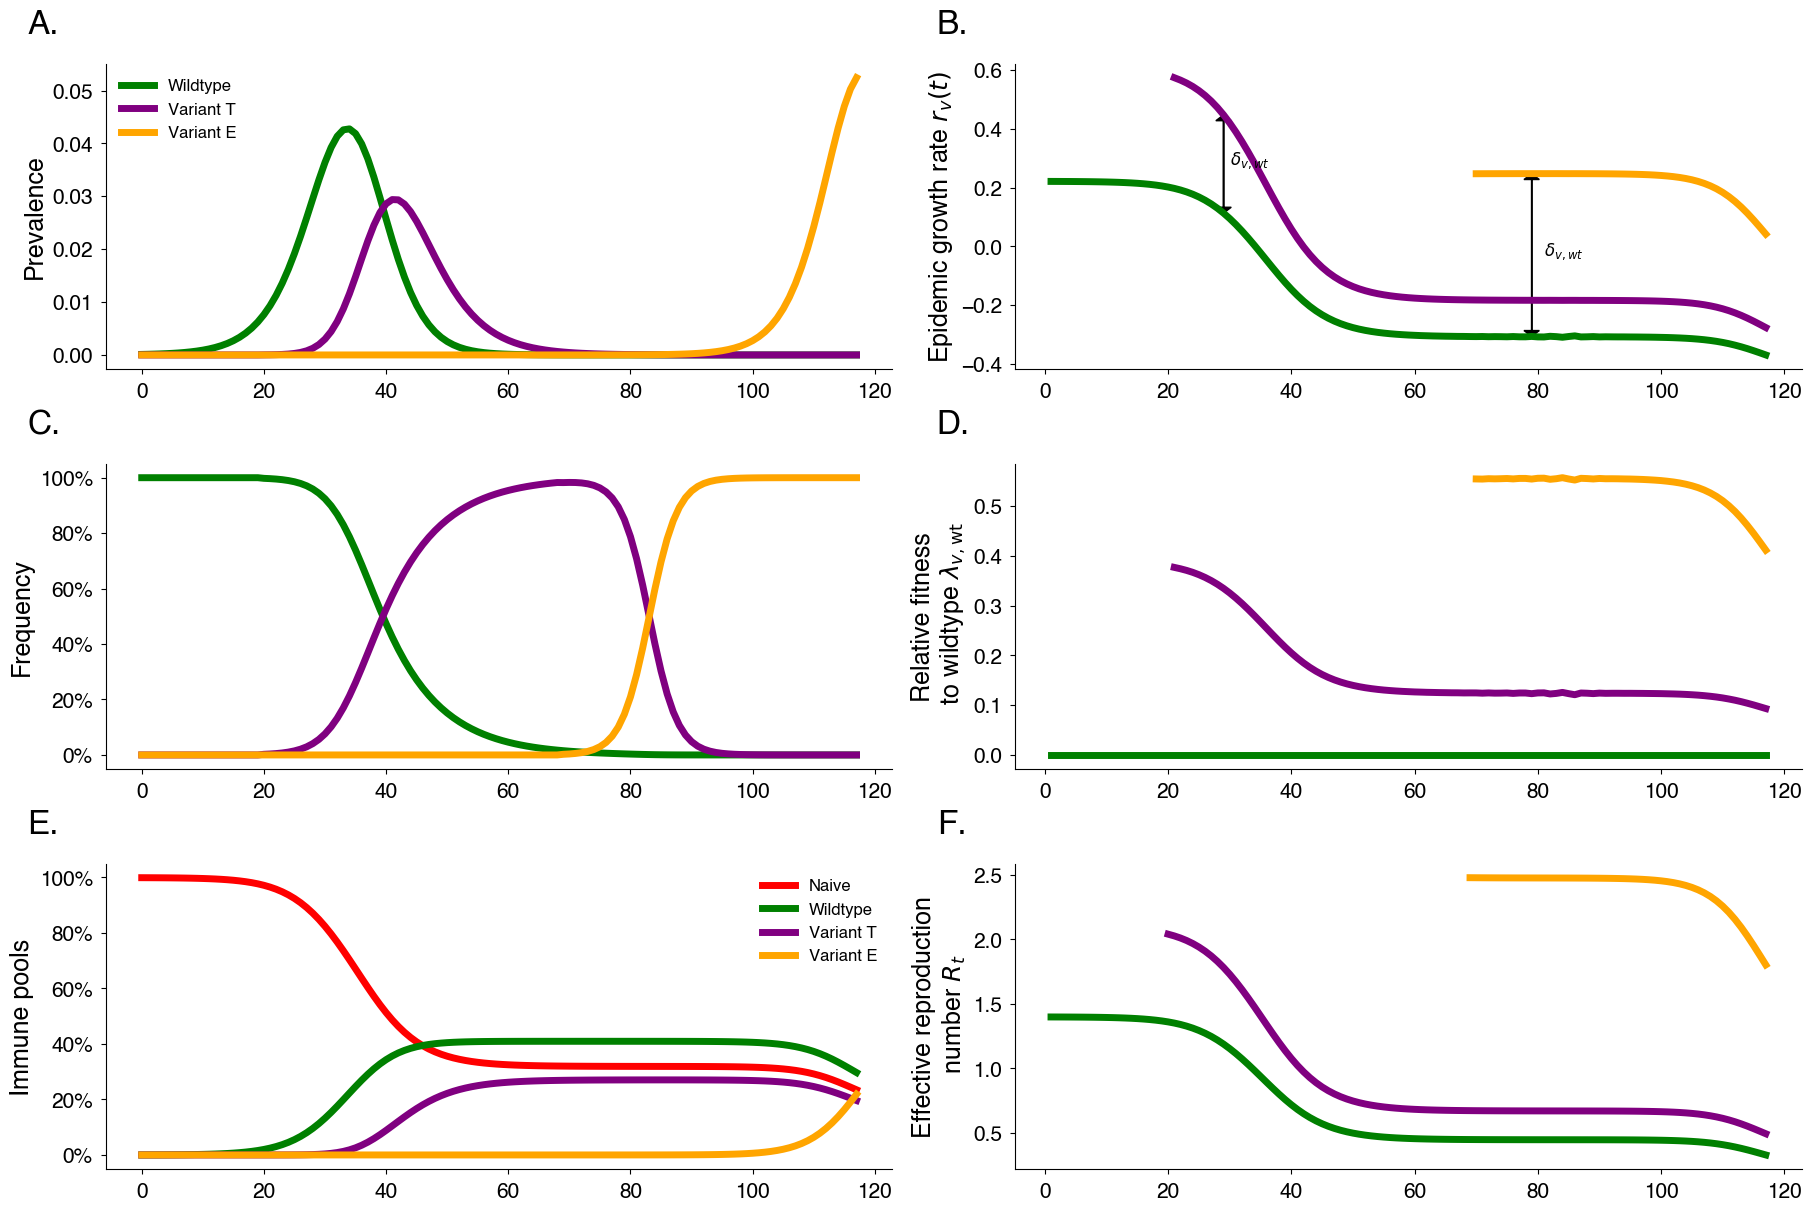

In [36]:
# Show prevalance, epidemic growth rate
WT_COLOR, VART_COLOR, VARE_COLOR = "green", "purple", "orange"
WT_LABEL, VART_LABEL, VARE_LABEL = "Wildtype", "Variant T", "Variant E"
COLOR_MAP = {WT_LABEL: WT_COLOR, VART_LABEL: VART_COLOR, VARE_LABEL: VARE_COLOR}

fig = plt.figure(figsize=(18., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=[1.0, 1.0])

# Plotting prevalence
ax_prev = fig.add_subplot(spec[0, 0])
ax_prev.plot(I_wt, color=WT_COLOR, label=WT_LABEL)
ax_prev.plot(I_vt, color=VART_COLOR, label=VART_LABEL)
ax_prev.plot(I_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_prev.set_ylabel("Prevalence")
ax_prev.legend(frameon=False)

# Plotting epidemic growth rate
def egr(Y):
    return jnp.diff(jnp.log(Y), prepend=jnp.nan)
    
ax_egr = fig.add_subplot(spec[0, 1])
ax_egr.plot(egr(I_wt), color=WT_COLOR)
ax_egr.plot(egr(I_vt), color=VART_COLOR)
ax_egr.plot(egr(I_ve), color=VARE_COLOR)

ax_egr.set_ylabel("Epidemic growth rate " + r"$r_v(t)$")

## Adding arrows
def add_arrows(ax, t, y1, y2, label, text_offset, horizontalalignment="left"):
    arrow_style = {
        "head_width": 2.5,
        "head_length": 0.02,
        "color":"k"
    }
    ax_egr.arrow(t, y1, dx=0, dy=y2-y1, **arrow_style, length_includes_head=True)
    ax_egr.arrow(t, y2, dx=0, dy=y1-y2, **arrow_style, length_includes_head=True)

    ax_egr.annotate(
        xy=(t, y1), 
        xytext=(t+text_offset, (y1+y2)/2),
        text=label,
        horizontalalignment=horizontalalignment)
    
annotate_t1, annotate_t2 = int(t1[-1] + 10), int(t2[-1] + 10)
egr_wt, egr_vt, egr_ve = egr(I_wt), egr(I_vt), egr(I_ve)

add_arrows(ax_egr, annotate_t1, egr_wt[annotate_t1], egr_vt[annotate_t1], r"$\delta_{v,wt}$", text_offset=1)
add_arrows(ax_egr, annotate_t2, egr_wt[annotate_t2], egr_ve[annotate_t2], r"$\delta_{v,wt}$", text_offset=2)

# Frequency
ax_freq = fig.add_subplot(spec[1, 0])
ax_freq.plot(I_wt / (I_wt + I_vt + I_ve), color=WT_COLOR, label=WT_LABEL)
ax_freq.plot(I_vt / (I_wt + I_vt + I_ve), color=VART_COLOR, label=VART_LABEL)
ax_freq.plot(I_ve / (I_wt + I_vt + I_ve), color=VARE_COLOR, label=VARE_LABEL)
ax_freq.set_ylabel("Frequency")
ax_freq.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Relative fitness
delta_wt = egr_wt - egr_wt
delta_ve = egr_ve - egr_wt
delta_vt = egr_vt - egr_wt

ind_wt = ~jnp.isnan(delta_wt)
ind_ve = ~jnp.isnan(delta_ve)
ind_vt = ~jnp.isnan(delta_vt)

ax_relfit = fig.add_subplot(spec[1, 1])
ax_relfit.plot(delta_wt, color=WT_COLOR, label=WT_LABEL)
ax_relfit.plot(delta_vt, color=VART_COLOR, label=VART_LABEL)
ax_relfit.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL)
ax_relfit.set_ylabel("Relative fitness\n to wildtype " + r"$\lambda_{v, \text{wt}}$")

# Add in immune pools
ax_immune = fig.add_subplot(spec[2, 0])
ax_immune.plot(S, color="red", label="Naive")
ax_immune.plot(phi_wt, color=WT_COLOR, label=WT_LABEL)
ax_immune.plot(phi_vt, color=VART_COLOR, label=VART_LABEL)
ax_immune.plot(phi_ve, color=VARE_COLOR, label=VARE_LABEL)
ax_immune.set_ylabel("Immune pools")
ax_immune.legend(frameon=False)
ax_immune.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add in Rt
ax_rt = fig.add_subplot(spec[2, -1])
ax_rt.plot(
    jnp.where(ind_wt, beta_wt * S / gam_wt, jnp.nan), 
    color=WT_COLOR, 
    label=WT_LABEL
)
ax_rt.plot(
    jnp.where(ind_vt, beta_wt * eta_T * S  / gam_wt, jnp.nan), 
    color=VART_COLOR,
    label=VART_LABEL
)
ax_rt.plot(
    jnp.where(ind_ve, beta_wt * eta_T * (eta_E * phi_wt + eta_E * phi_wt  + S) / gam_wt, jnp.nan),
    color=VARE_COLOR,
    label=VARE_LABEL
)
ax_rt.set_ylabel("Effective reproduction\n number " + r"$R_t$" )

import string
axes = [ax_prev, ax_egr, ax_freq, ax_relfit, ax_immune, ax_rt]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    
#TODO: Compute EGR by hand
#TODO: Comparing futures for variants with differnt properties at same starting point!

#Comment: Panel C things rise at similar point in time (?). 
    # How to highlight that different mechanim is explaining this difference?
    
fig.savefig(PRES_PATH + "vis_mechanisms.png")

In [7]:
# Estimating from sequence counts

# Simulate variant counts
def simulate_variant_counts(freqs, Ns):
    counts = []
    for t, n in enumerate(Ns):
        freq = (freqs[t,:] + 1e-6) / (freqs[t,:] + 1e-6).sum()
       # print(freq)
        counts.append(
            np.random.multinomial(n, freq)
        )
    return np.stack(counts)
    
    
# Convert prevalence to counts
freqs = np.vstack((I_vt, I_ve, I_wt)).T
freqs = freqs / freqs.sum(axis=-1)[:, None]

np.random.seed(14)
Ns = np.ones(freqs.shape[0]) * 100 # Number of sequences per day
Ns = np.random.binomial(Ns.astype(int), p=0.5)
variant_counts = simulate_variant_counts(freqs, Ns)

In [8]:
from evofr.data.variant_frequencies import variant_counts_to_dataframe

seq_counts = variant_counts_to_dataframe(variant_counts, var_names=[VART_LABEL, VARE_LABEL, WT_LABEL])
var_freq = ef.VariantFrequencies(seq_counts, pivot=WT_LABEL)

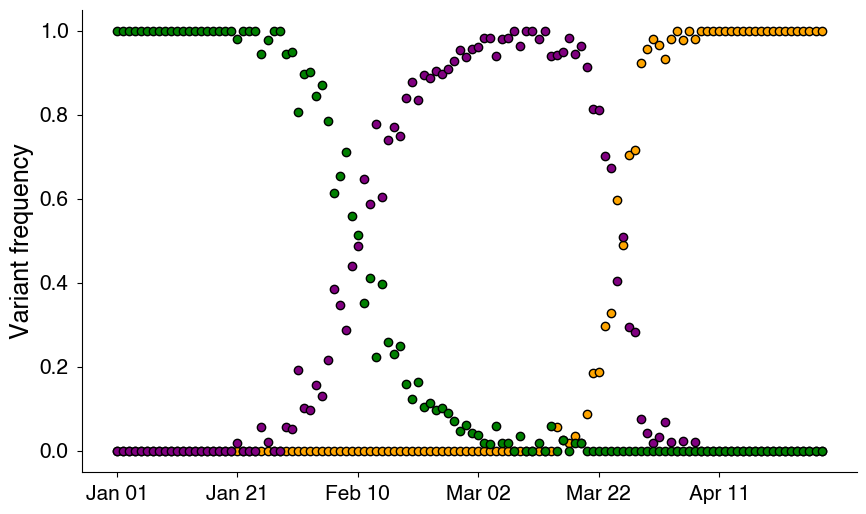

In [9]:
from evofr.plotting import FrequencyPlot, TimeVaryingPlot
FrequencyPlot(data=var_freq, color_map=COLOR_MAP).plot(posterior=False)

In [10]:
from relative_fitness_gp import RelativeFitnessGP, SquaredExpCov
model = ef.MultinomialLogisticRegression(tau=1.0)
model = RelativeFitnessGP(SquaredExpCov(alpha=0.15, rho=30.)) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=1000)
#inference_method = ef.InferMAP(lr=4e-4, iters=50_000)

#posterior = inference_method.fit(model, data=var_freq)

In [11]:
from relative_fitness_hsgp import RelativeFitnessHSGP, SquaredExponential, Matern
import numpyro.distributions as dist

model = ef.MultinomialLogisticRegression(tau=1.0)
hsgp_mat = Matern(
    L=250, 
    num_basis=50,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(0.1),
    nu=5/2)
hsgp_sq = SquaredExponential(
    L=180, 
    num_basis=45,
    rho = dist.HalfNormal(15),
    alpha = dist.HalfNormal(1e-2))
model = RelativeFitnessHSGP(hsgp_mat) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=1000)

posterior = inference_method.fit(model, data=var_freq)

sample: 100%|█| 1500/1500 [00:15<00:00, 96.79it/s, 1023 steps of size 3.05e-03. 


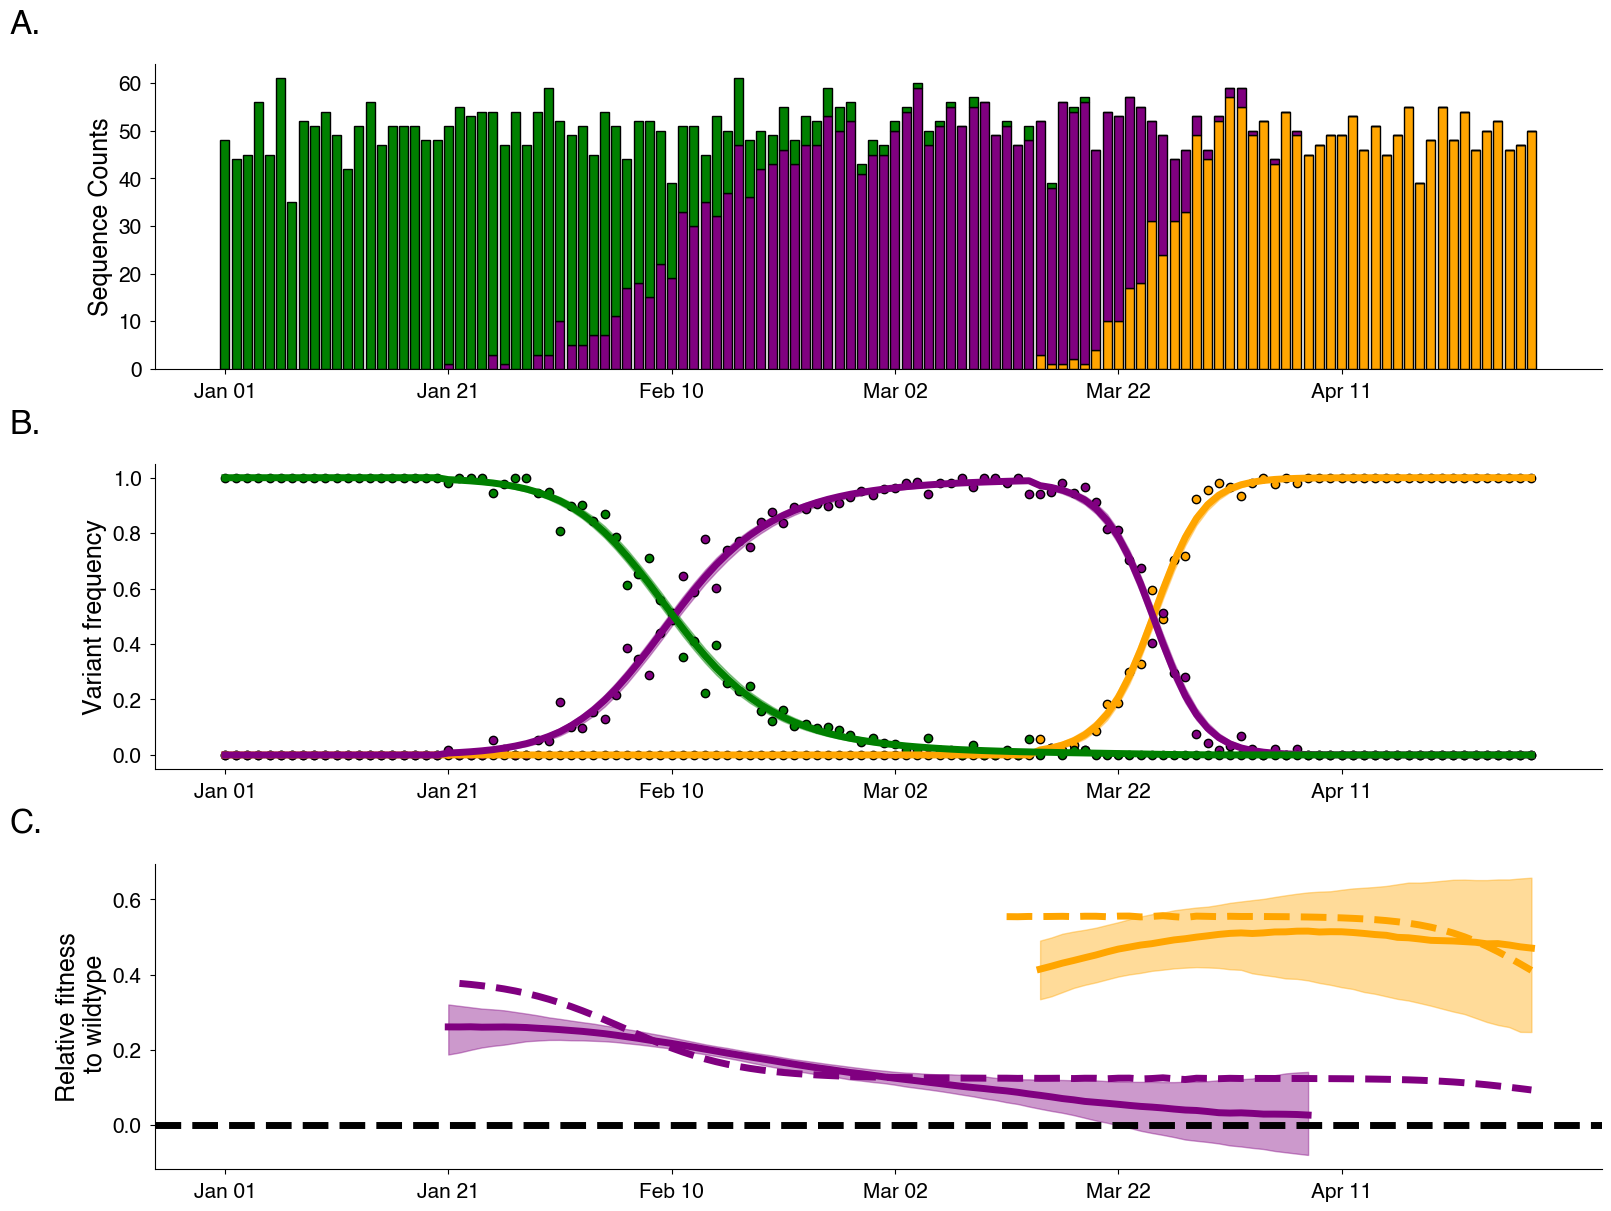

In [12]:
from evofr.plotting import add_dates_sep, prep_posterior_for_plot, plot_posterior_time
fig = plt.figure(figsize=(16., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3)

# Adding sequence counts,
def plot_observed_seq_counts(ax, LD, colors):
    obs_count = LD.seq_counts
    N_variant = obs_count.shape[-1]
    t = np.arange(0, obs_count.shape[0])
    bottom = np.zeros_like(t)
    for variant in range(N_variant):
        ax.bar(
            t, obs_count[:, variant], color=colors[variant], edgecolor="black", bottom=bottom
        )
        bottom = bottom + obs_count[:, variant]
        
ax_data = fig.add_subplot(spec[0])
plot_observed_seq_counts(ax_data, var_freq, [COLOR_MAP[c] for c in var_freq.var_names])
ax_data.set_ylabel("Sequence Counts")
add_dates_sep(ax_data, var_freq.dates, sep=20)

# Posterior frequency
ax_freq = fig.add_subplot(spec[1], sharex=ax_data)
FrequencyPlot(posterior, color_map=COLOR_MAP).plot(ax=ax_freq)

# Posterior Relative Fitness
delta_vt = egr_vt - egr_wt
delta_ve = egr_ve - egr_wt

ax_relfit = fig.add_subplot(spec[2], sharex=ax_freq)
ax_relfit.plot(delta_vt, color=VART_COLOR, label=VART_LABEL + "truth", linestyle = "--")
ax_relfit.plot(delta_ve, color=VARE_COLOR, label=VARE_LABEL + "truth", linestyle = "--")

add_dates_sep(ax_relfit, var_freq.dates, sep=20)
ax_relfit.set_ylabel("Relative fitness\n to wildtype")

## Add posterior estimate
_, n_times, _ = posterior.samples["delta"].shape

def plot_delta(ax, samples, ps, alphas, colors, forecast=False, plot_neutral_line=True, thres=1/1000):
    t, med, quants = prep_posterior_for_plot(
        "delta", samples, ps, forecast=forecast
    )
     # Plot only variants at high enough frequency
    _, freq_median, _ = prep_posterior_for_plot(
        "freq", samples, ps, forecast=forecast
    )
    included = freq_median > thres
    plot_posterior_time(ax, t, med, quants, alphas, colors, included=included)
    return None

plot_delta(ax_relfit, posterior.samples, ps=[0.8], alphas=[0.4], colors=[COLOR_MAP[c] for c in var_freq.var_names])
ax_relfit.axhline(y=0.0, color="k", linestyle="--")

axes = [ax_data, ax_freq, ax_relfit]
ax_labels = string.ascii_uppercase 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    
fig.savefig(PRES_PATH + "gp_example.png")

In [13]:
# Figure 3: Time to x% for each variant based on mechanisms / immune pools. (Think invasion analysis)

# Figure 4: 

# Figure 5: Models can still be predictive even if they don't know everythign about mechanism. For example, including that things should generally trend downward!

In [14]:
# Using mean function to deconvolve things
# TODO: Add forecasts for these models!!

## Selective pressure

In [15]:


def compute_selective_pressure(posterior):
    delta = posterior.samples["delta"]
    num_samples, T, _ = delta.shape
    delta = jnp.concatenate((delta, jnp.zeros((num_samples,T,1))), axis=-1)
    freq = posterior.samples["freq"]        
        
    # Mean fitness
    delta_bar = (delta * freq).sum(axis=-1)
    
    # Mean square deviation
    delta_sse = jnp.square(delta - delta_bar[..., None])
    selective_pressure_var = (delta_sse * freq).sum(axis=-1)
    
    # Change in relative fitness overall
    selective_pressure_expect = (jnp.diff(delta, axis=-2, prepend=jnp.nan) * freq).sum(axis=-1)
    selective_pressure = selective_pressure_var + selective_pressure_expect
    
    return delta_bar, selective_pressure

posterior.samples["delta_bar"] , posterior.samples["selective_pressure"] = compute_selective_pressure(posterior)

Text(0, 0.5, 'Selective pressure')

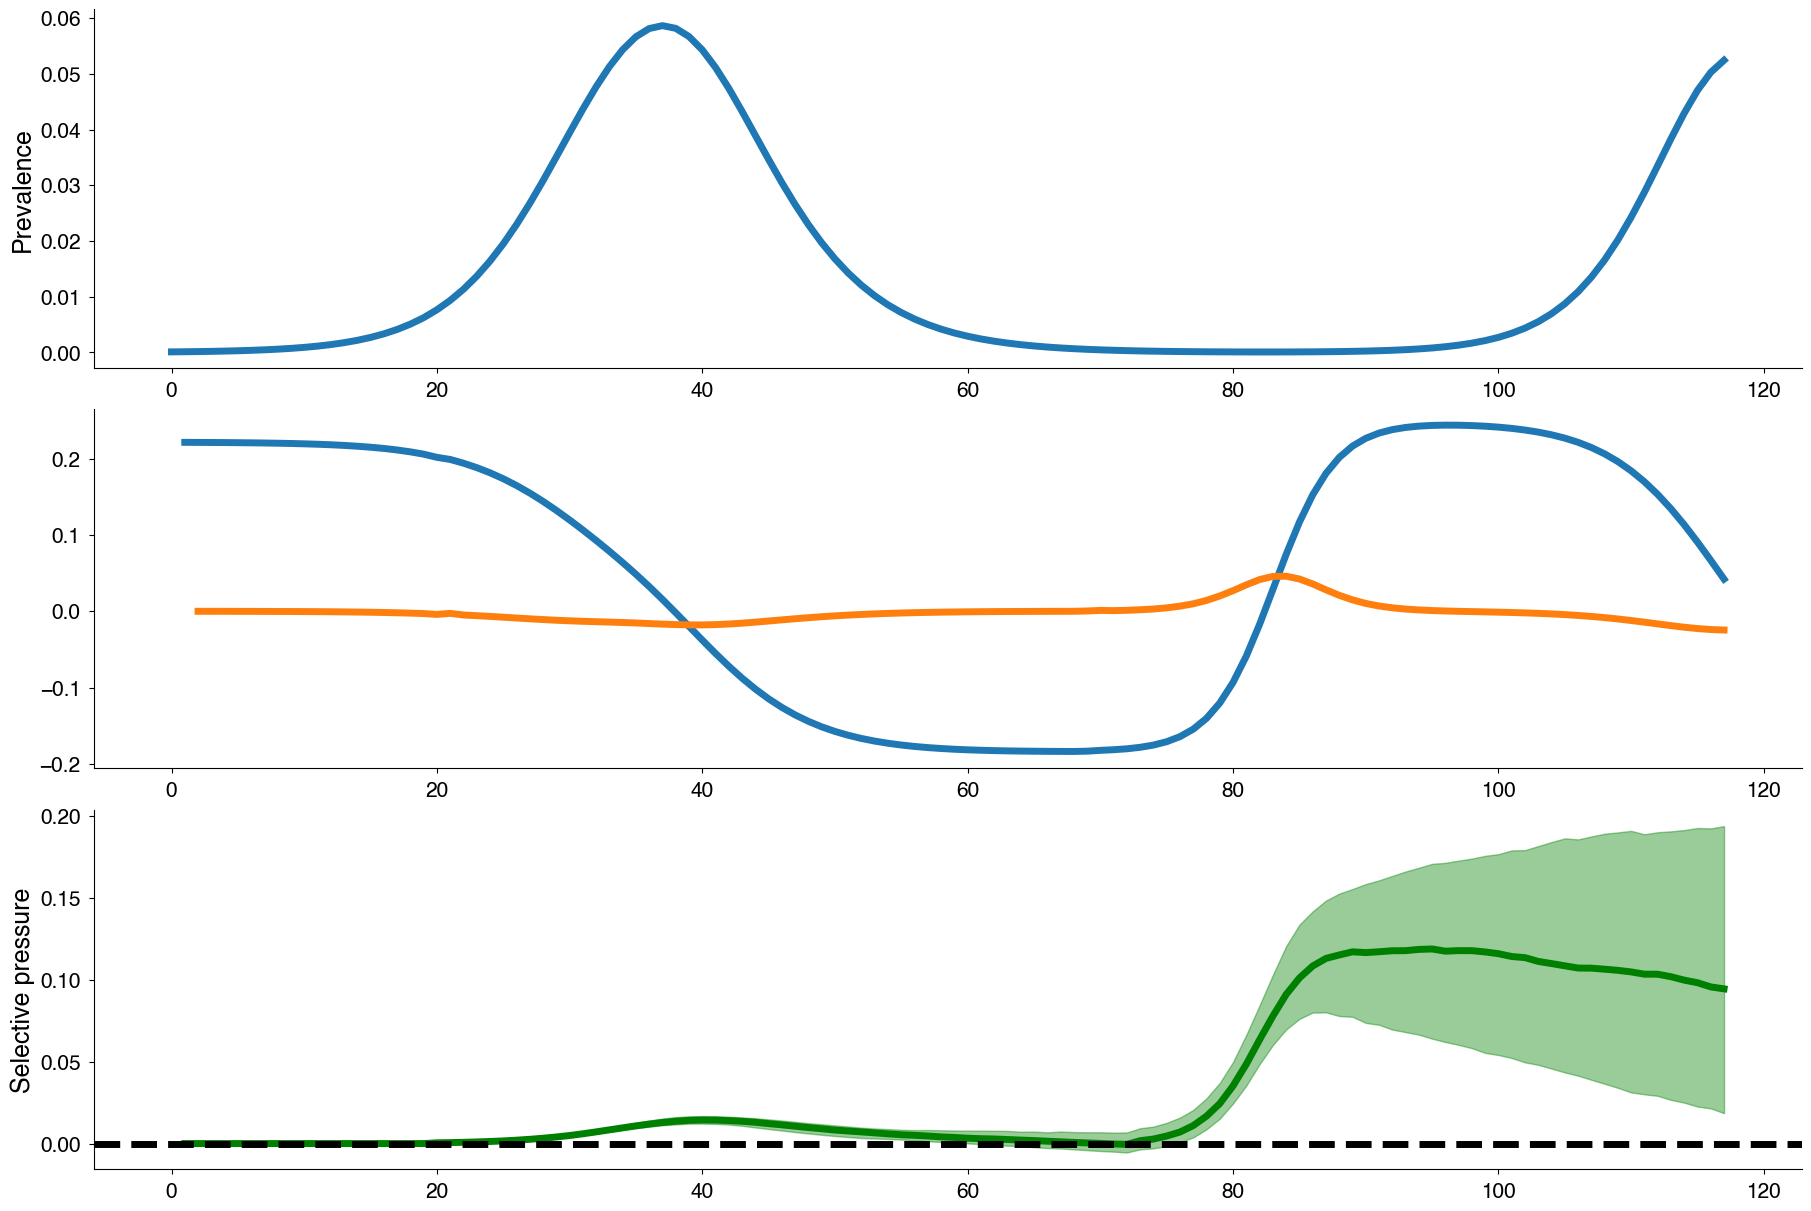

In [24]:
fig = plt.figure(figsize=(18., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3)

# Plotting prevalence
ax_prev = fig.add_subplot(spec[0])
#ax_prev.plot(I_wt, color=WT_COLOR, label=WT_LABEL)
#ax_prev.plot(I_vt, color=VART_COLOR, label=VART_LABEL)
#ax_prev.plot(I_ve, color=VARE_COLOR, label=VARE_LABEL)

ax_prev.plot(I_wt + I_vt + I_ve)

ax_prev.set_ylabel("Prevalence")
ax_prev.legend(frameon=False)

# Plotting growth rates
ax_egr = fig.add_subplot(spec[1], sharex=ax_prev)

egr_wt, egr_vt, egr_ve = egr(I_wt), egr(I_vt), egr(I_ve)
true_egrs = np.array([egr_wt, egr_vt, egr_ve]).T
true_egrs = np.nan_to_num(true_egrs, nan=0,  posinf=0, neginf=0)
true_egrs[0, :] = np.nan

true_freqs = np.array([I_wt, I_vt, I_ve]).T
true_freqs = true_freqs / true_freqs.sum(axis=-1)[:, None]

average_egr = (true_egrs * true_freqs).sum(axis=-1)

#ax_egr.plot((true_egrs * true_freqs))
ax_egr.plot(average_egr)
ax_egr.plot(np.diff(average_egr, prepend=np.nan))


# Plotting selective pressure
def plot_selective_pressure(ax, samples, ps, alphas, color, forecast=False, plot_neutral_line=True, thres=1/1000):
    t, med, quants = prep_posterior_for_plot(
        "selective_pressure", samples, ps, forecast=forecast
    )
    ax.plot(t, med, color=color)
    for i, alpha in enumerate(alphas):
        ax.fill_between(t,  quants[i][0, :], quants[i][1, :], alpha=alpha, color=color)
    return None

ax_selective_pressure = fig.add_subplot(spec[2], sharex=ax_prev)
plot_selective_pressure(ax_selective_pressure, posterior.samples, ps=[0.8], alphas=[0.4], color=WT_COLOR)
ax_selective_pressure.axhline(y=0.0, color="k", linestyle="--")
ax_selective_pressure.set_ylabel("Selective pressure")